In [355]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [356]:
import numpy as np
import xgi
from governance import *
import matplotlib.pyplot as plt

In [357]:
def create_decision_matrix(m):
    D = np.zeros((m, m))
    for i in range(m):
        for j in range(i):
            D[j, i] = D[i, j] = random.choice([-1, 0, 1])
    return D

def create_random_opinions(n, m):
    D = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            #D[i, j] = random.choice([-1, 0, 1])
            #D[i, j] = random.uniform(-1, 1)
            if random.uniform(0, 1)>0.4:
                D[i,j] = random.uniform(0, 1)
            else:
                D[i,j] = random.uniform(-1, 0)
    return D

def decisions_to_array(decisions):
    n = len(decisions)
    d = np.zeros(n)
    for key, val in decisions.items():
        if val == 1:
            d[key] = 1
        else:
            d[key] = -1
    return d

def truncated_normal(mean, std, bounds):
    x = np.random.normal(mean, std)
    while x <= bounds[0] or x >= bounds[1]:
        x = np.random.normal(mean, std)
    return x

def create_polarized_opinions(n, m, d, inform, pol):
    D = np.zeros((n, m))
    for i in range(n):
        if random.uniform(0, 1)>inform: #dumb agent
            for j in range(m):
                D[i,j] = truncated_normal(0, 0.25,[-1,1])
        elif random.uniform(0, 1)<pol:
            for j in range(m):
                D[i,j] = truncated_normal(0.5*d[j], 0.25,[-1,1])
        else:
            for j in range(m):
                D[i,j] = truncated_normal(-0.5*d[j], 0.25,[-1,1])
    return D


def create_mixed_opinions(n, m, d, inform, pol):
    D = np.zeros((n, m))
    for i in range(n):
        if random.uniform(0, 1)>inform: #dumb agent
            for j in range(m):
                D[i,j] = truncated_normal(0, 0.25,[-1,1])
        elif random.uniform(0, 1)<pol:
            for j in range(m):
                D[i,j] = truncated_normal(d[j], 0.25,[-1,1])
        else:
            for j in range(m):
                D[i,j] = truncated_normal(1-d[j], 0.25,[-1,1])
    return D

In [358]:
num_decisions = 6
num_people = 10000

select_decision_type = "snowball"
select_group_type = "star"
make_decision_type = "average"
update_opinions_type = "star"

#opinions = create_opinions(num_people, num_decisions)
opinions = create_polarized_opinions(num_people, num_decisions,[1,-1,-1,-1,-1,1],0.2,0.2)
votes = 2*(np.mean(opinions, axis=0)>0)-1
print(votes)
#decision_matrix = create_decision_matrix(num_decisions)
decision_matrix = np.array([[0,-1,-1,-1,-1,1],[-1,0,0,0,0,0],[-1,0,0,0,0,0],[-1,0,0,0,0,0],[-1,0,0,0,0,0],[1,0,0,0,0,0]])
print(decision_matrix)

[-1  1  1  1  1 -1]
[[ 0 -1 -1 -1 -1  1]
 [-1  0  0  0  0  0]
 [-1  0  0  0  0  0]
 [-1  0  0  0  0  0]
 [-1  0  0  0  0  0]
 [ 1  0  0  0  0  0]]


In [359]:
group_size = 26
overlap = 25

#opinions = create_opinions(num_people, num_decisions)
opinions = create_polarized_opinions(num_people, num_decisions,[1,-1,-1,-1,-1,1],0.2,0.2)
decisions, final_opinions, decision_groups = decision_process(opinions, decision_matrix, group_size, overlap, select_decision_type=select_decision_type, select_group_type=select_group_type, make_decision_type=make_decision_type, update_opinions_type=update_opinions_type)
# d = decisions_to_array(decisions)
coherence = 0
for d1, d2 in np.ndindex(decision_matrix.shape):
    coherence += decision_matrix[d1,d2]*decisions[d1]*decisions[d2]
print(decisions)
print(coherence)

{4: 1.0, 0: -1.0, 1: 1.0, 5: -1.0, 2: 1.0, 3: 1.0}
10.0


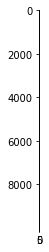

In [360]:
plt.imshow(final_opinions-opinions)

In [361]:
print(decisions)
coherence=0
for d1, d2 in np.ndindex(decision_matrix.shape):
    coherence += decision_matrix[d1,d2]*decisions[d1]*decisions[d2]
print(coherence)

{4: 1.0, 0: -1.0, 1: 1.0, 5: -1.0, 2: 1.0, 3: 1.0}
10.0


<AxesSubplot: >

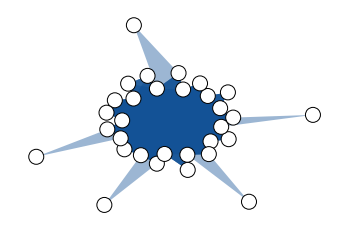

In [362]:
xgi.draw(decision_groups)

In [ ]:
num_samples = 500
group_sizes = np.arange(1, 51, 2, dtype=int)
satisfaction_group_size = np.zeros(len(group_sizes))
satisfiability_group_size = np.zeros(len(group_sizes))
overlap = 0
H_group_sizes = dict()

for i in range(len(group_sizes)):
    g = group_sizes[i]
    for j in range(num_samples):
        if j%100==0:
            print(i/len(group_sizes), j/num_samples)
        #opinions = create_random_opinions(num_people, num_decisions)
        opinions = create_polarized_opinions(num_people, num_decisions,[1,-1,-1,-1,-1,1],0.33,0.6)
        #opinions = create_mixed_opinions(num_people, num_decisions,[0.6,-0.4,-0.4,-0.4,-0.4,0.6],0.0,0.6)
        #binary_votes = 2*(np.mean(opinions, axis=0)>0)-1
        votes = np.mean(opinions, axis=0)
        decisions, final_opinions, decision_groups = decision_process(opinions, decision_matrix, g, overlap, select_decision_type=select_decision_type, select_group_type=select_group_type, make_decision_type=make_decision_type, update_opinions_type=update_opinions_type)
        #H_group_sizes[(g, overlap, j)] = decision_groups
        d = decisions_to_array(decisions)
        #satisfaction_group_size[i] += np.mean(opinions.dot(d))/num_samples
        satisfaction_group_size[i] += votes.dot(d)/num_samples
        for d1, d2 in np.ndindex(decision_matrix.shape):
            satisfiability_group_size[i] += decision_matrix[d1,d2]*decisions[d1]*decisions[d2]/num_samples

0.0 0.0
0.0 0.2
0.0 0.4
0.0 0.6
0.0 0.8
0.04 0.0
0.04 0.2
0.04 0.4
0.04 0.6
0.04 0.8
0.08 0.0
0.08 0.2
0.08 0.4
0.08 0.6
0.08 0.8
0.12 0.0
0.12 0.2
0.12 0.4
0.12 0.6
0.12 0.8
0.16 0.0
0.16 0.2
0.16 0.4
0.16 0.6
0.16 0.8
0.2 0.0
0.2 0.2
0.2 0.4
0.2 0.6
0.2 0.8
0.24 0.0
0.24 0.2
0.24 0.4
0.24 0.6
0.24 0.8
0.28 0.0
0.28 0.2
0.28 0.4
0.28 0.6
0.28 0.8
0.32 0.0
0.32 0.2
0.32 0.4
0.32 0.6
0.32 0.8
0.36 0.0
0.36 0.2
0.36 0.4
0.36 0.6
0.36 0.8
0.4 0.0
0.4 0.2
0.4 0.4
0.4 0.6
0.4 0.8
0.44 0.0
0.44 0.2
0.44 0.4
0.44 0.6
0.44 0.8
0.48 0.0
0.48 0.2
0.48 0.4
0.48 0.6
0.48 0.8
0.52 0.0
0.52 0.2
0.52 0.4
0.52 0.6
0.52 0.8
0.56 0.0
0.56 0.2
0.56 0.4
0.56 0.6
0.56 0.8
0.6 0.0
0.6 0.2
0.6 0.4
0.6 0.6
0.6 0.8
0.64 0.0
0.64 0.2
0.64 0.4
0.64 0.6
0.64 0.8
0.68 0.0
0.68 0.2
0.68 0.4
0.68 0.6
0.68 0.8
0.72 0.0
0.72 0.2
0.72 0.4
0.72 0.6
0.72 0.8
0.76 0.0
0.76 0.2
0.76 0.4
0.76 0.6
0.76 0.8
0.8 0.0
0.8 0.2
0.8 0.4


In [ ]:
num_samples = 500
overlap_sizes = np.arange(0, 20+1, 2, dtype=int)
satisfaction_overlap_size = np.zeros(len(overlap_sizes))
satisfiability_overlap_size = np.zeros(len(overlap_sizes))
group_size = max(overlap_sizes) + 1

H_overlap_sizes = dict()

for i in range(len(overlap_sizes)):
    o = overlap_sizes[i]
    for j in range(num_samples):
        if j%100==0:
            print(i/len(overlap_sizes), j/num_samples)
        #opinions = create_random_opinions(num_people, num_decisions)
        opinions = create_polarized_opinions(num_people, num_decisions,[1,-1,-1,-1,-1,1],0.33,0.6)
        #opinions = create_mixed_opinions(num_people, num_decisions,[0.6,-0.4,-0.4,-0.4,-0.4,0.6],0.0,0.6)
        #binary_votes = 2*(np.mean(opinions, axis=0)>0)-1
        votes = np.mean(opinions, axis=0)
        decisions, final_opinions, decision_groups = decision_process(opinions, decision_matrix, group_size, o, select_decision_type=select_decision_type, select_group_type=select_group_type, make_decision_type=make_decision_type, update_opinions_type=update_opinions_type)
        H_overlap_sizes[(group_size, o, j)] = decision_groups
        d = decisions_to_array(decisions)
        #satisfaction_overlap_size[i] += np.mean(opinions.dot(d))/num_samples
        satisfaction_overlap_size[i] += votes.dot(d)/num_samples
        for d1, d2 in np.ndindex(decision_matrix.shape):
            satisfiability_overlap_size[i] += decision_matrix[d1,d2]*decisions[d1]*decisions[d2]/num_samples

In [ ]:
plt.figure()
plt.subplot(211)
plt.plot(group_sizes, satisfaction_group_size,'ko-', linewidth=1, markersize=5)
plt.ylabel("Average satisfaction")
plt.xlabel("Group size")
plt.subplot(212)
plt.plot(overlap_sizes, satisfaction_overlap_size,'ko-', linewidth=1, markersize=5)
plt.ylabel("Average satisfaction")
plt.xlabel("Overlap size")
plt.tight_layout()
plt.savefig("democratic.pdf")
plt.show()

In [ ]:
plt.figure()
plt.subplot(211)
plt.plot(group_sizes, satisfiability_group_size,'ko-', linewidth=1, markersize=5)
plt.ylabel("Average coherence")
plt.xlabel("Group size")
plt.subplot(212)
plt.plot(overlap_sizes, satisfiability_overlap_size,'ko-', linewidth=1, markersize=5)
plt.ylabel("Average coherence")
plt.xlabel("Overlap size")
plt.tight_layout()
plt.savefig("coherence.pdf")
plt.show()

In [ ]:
plt.figure()
plt.subplot(221)
plt.plot(group_sizes, satisfaction_group_size,'ko-', linewidth=1, markersize=5)
plt.ylabel("Average satisfaction")
plt.xlabel("Group size")
plt.subplot(222)
plt.plot(overlap_sizes, satisfaction_overlap_size,'ko-', linewidth=1, markersize=5)
plt.ylabel("Average satisfaction")
plt.xlabel("Overlap size")
plt.subplot(223)
plt.plot(group_sizes, satisfiability_group_size,'ko-', linewidth=1, markersize=5)
plt.ylabel("Average coherence")
plt.xlabel("Group size")
plt.subplot(224)
plt.plot(overlap_sizes, satisfiability_overlap_size,'ko-', linewidth=1, markersize=5)
plt.ylabel("Average coherence")
plt.xlabel("Overlap size")
plt.tight_layout()
plt.savefig("complete.pdf")
plt.show()

In [349]:
xgi.draw(H_overlap_sizes[(31, 5, 5)], xgi.pairwise_spring_layout(H_overlap_sizes[(31, 5, 5)]), node_size=5) 

KeyError: (31, 5, 5)

## 